In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.serialize import model_to_json, model_from_json

In [224]:
dataset_path = '../data/'

pollen_test = pd.read_csv(dataset_path + 'pollen_test.csv')
pollen_train = pd.read_csv(dataset_path + 'pollen_train.csv')
pollen_type = pd.read_csv(dataset_path + 'pollen-type.csv')
submission_example = pd.read_csv(dataset_path + 'submission_example.csv')
weather_data = pd.read_csv(dataset_path + 'weather_data.csv')

In [225]:
pollen_train.head()

,Unnamed: 0,location,date,ACER,ALNUS,AMBROSIA,ARTEMISIA,BETULA,CANNABACEAE,CARPINUS,...,PLANTAGO,PLATANUS,POACEAE,POPULUS,QUERCUS,RUMEX,SALIX,TILIA,ULMACEAE,URTICACEAE
0,265,БЕОГРАД - НОВИ БЕОГРАД,2016-02-02,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,266,БЕОГРАД - НОВИ БЕОГРАД,2016-02-03,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,0
2,267,БЕОГРАД - НОВИ БЕОГРАД,2016-02-04,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,268,БЕОГРАД - НОВИ БЕОГРАД,2016-02-05,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,269,БЕОГРАД - НОВИ БЕОГРАД,2016-02-06,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0


In [226]:
# fill nonexisting dates with 0 for every column

pollen_train['date'] = pd.to_datetime(pollen_train['date'])
pollen_train = pollen_train.set_index('date')
pollen_train = pollen_train.resample('D').sum()
pollen_train = pollen_train.reset_index()
pollen_train['date'] = pd.to_datetime(pollen_train['date'])

pollen_train.head()

,date,Unnamed: 0,ACER,ALNUS,AMBROSIA,ARTEMISIA,BETULA,CANNABACEAE,CARPINUS,CELTIS,...,PLANTAGO,PLATANUS,POACEAE,POPULUS,QUERCUS,RUMEX,SALIX,TILIA,ULMACEAE,URTICACEAE
0,2016-02-01,20824,0,38,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2016-02-02,21095,0,117,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
2,2016-02-03,21102,2,65,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,8,0
3,2016-02-04,21109,0,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2016-02-05,21116,0,21,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [227]:
# pick 'date' and 'AMBROSIA' columns and change their name to 'ds' and 'y' respectively
# deep copy the dataframe

pollen_df = pollen_train.copy()

# change the column names
pollen_df['ds'] = pollen_df['date']
pollen_df['y'] = pollen_df['AMBROSIA']

pollen_df.drop(['Unnamed: 0', 'date', 'AMBROSIA'], axis=1, inplace=True)

pollen_df['cap'] = 2500
pollen_df['floor'] = 0

pollen_df.head()

,ACER,ALNUS,ARTEMISIA,BETULA,CANNABACEAE,CARPINUS,CELTIS,CHENOP/AMAR.,CORYLUS,CUPRESS/TAXA.,...,QUERCUS,RUMEX,SALIX,TILIA,ULMACEAE,URTICACEAE,ds,y,cap,floor
0,0,38,0,0,0,0,0,0,167,9,...,0,0,0,0,0,0,2016-02-01,0,2500,0
1,0,117,0,0,0,0,0,0,300,133,...,0,0,0,0,2,0,2016-02-02,0,2500,0
2,2,65,0,0,0,0,0,0,517,119,...,0,0,0,0,8,0,2016-02-03,0,2500,0
3,0,9,0,0,0,0,0,0,71,17,...,0,0,0,0,1,0,2016-02-04,0,2500,0
4,0,21,0,0,0,0,0,0,83,10,...,0,0,0,0,0,0,2016-02-05,0,2500,0


In [228]:
max(pollen_df['y'])

2445

## Model

In [229]:
# Split the data into train and test sets

train_df = pollen_df[:int(0.8*(len(pollen_df)))]
test_df = pollen_df[int(0.8*(len(pollen_df))):]

In [233]:
# define the model
model = prophet.Prophet(growth='logistic', interval_width=0.80)
# fit the model
model.fit(train_df)

16:15:32 - cmdstanpy - INFO - Chain [1] start processing
16:15:33 - cmdstanpy - INFO - Chain [1] done processing


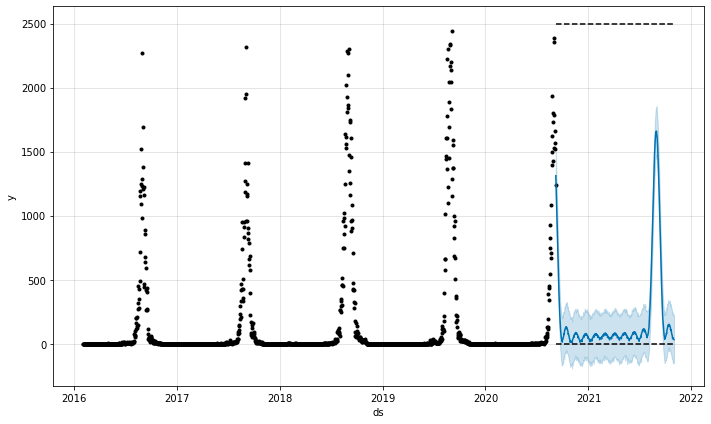

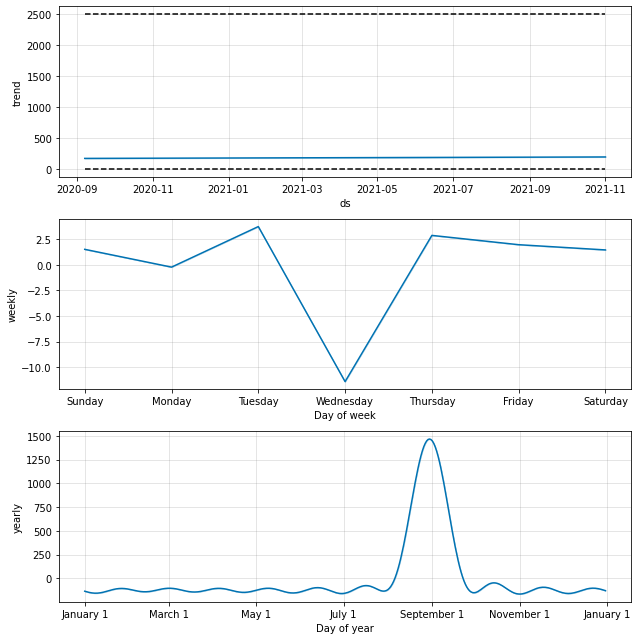

In [239]:
future = model.predict(test_df)
future['cap'] = 2500
future['floor'] = 0
fcst = model.predict(future)

fig = model.plot(fcst)
fig = model.plot_components(fcst)

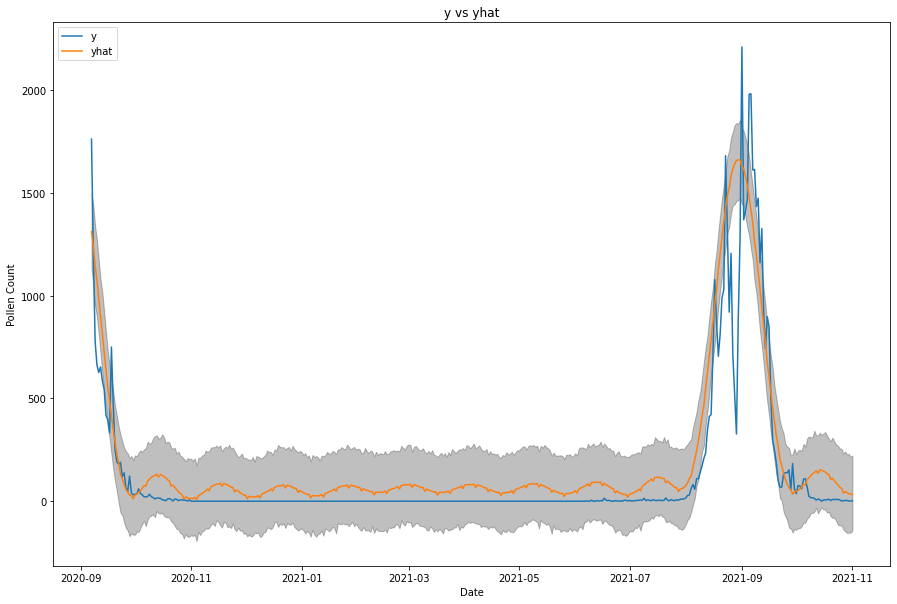

In [242]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.plot(test_df['ds'], test_df['y'], label='y')
ax.plot(fcst['ds'], fcst['yhat'], label='yhat')
ax.fill_between(fcst['ds'], fcst['yhat_lower'], fcst['yhat_upper'], color='k', alpha=0.25)
ax.set_title('y vs yhat')
ax.set_xlabel('Date')
ax.set_ylabel('Pollen Count')
plt.legend(loc='upper left')

## Save Model

In [245]:
with open('../models/prophet.json', 'w') as fout:
    print("?")
    fout.write(model_to_json(model))  # Save model

?
